# Analyse des ressentis avec GloVe Vectors

L'analyse des ressentis a pour objectif de classifier les opinions exprimées sous forme de texte dans un langage naturel. Différentes méthodes peuvent être utlisées pour réaliser cette analyse. Dans cet exemple, des commentaires recueillis surle site [allociné](http://www.allocine.fr/) vont être utlisés pour entrainer un modèle de classification supervisé. Le modèle utilise un réseau de neurones à convolution 1D.

Les mots contenus dans les phrases doivent être encodés dans des vecteurs qui seront utilisés pour l'entrainement et les tests. Une manière simple serait d'assigner à chaque mot une valeur numérique. Le problème de cette méthode est que le contexte dans lequel les mots sont utilisés n'est pas pris en compte. Une méthode permettant de combler ce manque est d'utiliser un algorithme de prolongation lexicale (Word embedding). Parmi ce genre d'algorithme, on trouve [GloVe (Global Vectors for Word Representation)](https://nlp.stanford.edu/projects/glove/) qui se base sur les probabilités de co-occurence de mots. Une base de données pré-entrainée (mais en Anglais) est déjà disponnible sur leur site web.  

Une base de donnée pré-entrainée en Français peut-être néanmoins téléchargée à cette [adresse](http://www.cs.cmu.edu/~afm/projects/multilingual_embeddings.html). C'est celle-ci que nous utiliserons.

In [1]:
import pandas as pd
import numpy as np
import random
import json

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Chargement des données d'entrainement

Les données d'entrainement sont chargées dans une dataframe Panda depuis des fichiers textes. Ces données contiennent deux colonnes : Un commentaire et une valeur binaire définissant un sentiment négatif ou positif sur ce commentaire. 

Ces données sont disponnibles sur le github de [TheophileBlard](https://github.com/TheophileBlard/french-sentiment-analysis-with-bert/tree/master/allocine_dataset). Ces données sont issues de commentaires récupérés sur Allociné. Les utilisateurs votent avec des notes allant de 0.5 à 5.0 :    
<img src="https://github.com/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Images/rating_counts.png?raw=1" width="600"/>

Afin de récupérer une note binaire (négative ou positive) à partir de cet intervalle de valeurs, les votes <= 2 sont classé comme négatifs et ceux >=4 sont classés comme positifs. Les autres sont classés comme neutres :    
<img src="https://github.com/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Images/polarity_frequency.png?raw=1" width="600"/>  
  

Enfin, pour construire les données, 100 000 avis négatifs et 100 000 avis positifs sont extraits aléatoirement, puis décomposés en deux catégories : Les données d'entrainement (80%), les données de test (10%) et les données de validation (10%) :  
<img src="https://github.com/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Images/splits_polarity.png?raw=1" width="600"/>  



In [2]:
# Téléchargement des données depuis le repot github "https://github.com/AlexandreBourrieau/ML-F1/raw/master/Carnets%20Jupyter/Donn%C3%A9es/data.tar.bz2"

!wget "https://github.com/AlexandreBourrieau/ML-F1/raw/master/Carnets%20Jupyter/Donn%C3%A9es/data.tar.bz2"
!tar -xjvf data.tar.bz2
!ls -l data

--2020-09-13 17:25:49--  https://github.com/AlexandreBourrieau/ML-F1/raw/master/Carnets%20Jupyter/Donn%C3%A9es/data.tar.bz2
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AlexandreBourrieau/ML-F1/master/Carnets%20Jupyter/Donn%C3%A9es/data.tar.bz2 [following]
--2020-09-13 17:25:49--  https://raw.githubusercontent.com/AlexandreBourrieau/ML-F1/master/Carnets%20Jupyter/Donn%C3%A9es/data.tar.bz2
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66625305 (64M) [application/octet-stream]
Saving to: ‘data.tar.bz2’

data.tar.bz2        100%[===================>]  63.54M   130MB/s    in 0.5s    

2020-09-13

In [3]:
DataEntrainement = pd.read_json("/content/data/test.jsonl", lines=True)
DataEntrainement.head(10)

,film-url,review,polarity
0,http://www.allocine.fr/film/fichefilm-25385/cr...,"Magnifique épopée, une belle histoire, touchan...",1
1,http://www.allocine.fr/film/fichefilm-1954/cri...,Je n'ai pas aimé mais pourtant je lui mets 2 é...,0
2,http://www.allocine.fr/film/fichefilm-135523/c...,Un dessin animé qui brille par sa féerie et se...,1
3,http://www.allocine.fr/film/fichefilm-61514/cr...,"Si c'est là le renouveau du cinéma français, c...",0
4,http://www.allocine.fr/film/fichefilm-260395/c...,Et pourtant on s’en Doutait !Second volet très...,0
5,http://www.allocine.fr/film/fichefilm-220641/c...,Vous reprendrez bien un peu d'été ? Ce film je...,1
6,http://www.allocine.fr/film/fichefilm-120103/c...,Bon c'est pas un grand film mais on passe un b...,1
7,http://www.allocine.fr/film/fichefilm-190956/c...,"Terrible histoire que ces êtres sans amour, ce...",1
8,http://www.allocine.fr/film/fichefilm-186185/c...,"Un très joli film, qui ressemble à un téléfilm...",1
9,http://www.allocine.fr/film/fichefilm-17327/cr...,Mais comment certaines personnes ont pus lui m...,0


# Chargement des vecteurs GloVe et préparation des données

**Commençons par charger les vecteurs GloVe**  

Les fichiers des vecteurs GloVe sont téléchargés à partir du site de [GloVe](https://nlp.stanford.edu/projects/glove/) mais ils sont en Anglais. Nous allons utiliser une [version française](http://www.cs.cmu.edu/~afm/projects/multilingual_embeddings.html) équivalente.  
  
Le fichier que nous utilisons contient plus de 40000 vecteurs de dimension 300. Cela signifie que pour chaque mot contenu dans ce fichier, un vecteur de 300 valeurs permet de définir les relations lexicales de ce mots avec les autres mots du fichier.  

<img src="https://github.com/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Images/EmbeddedVectors.png?raw=1"/>  

In [4]:
# Téléchargement des vecteurs
!wget "https://github.com/AlexandreBourrieau/ML-F1/raw/master/Carnets%20Jupyter/Donn%C3%A9es/multilingual_embeddings.rar"
!mv multilingual_embeddings.rar /content/data/multilingual_embeddings.rar
!unrar x /content/data/multilingual_embeddings.rar /content/data

--2020-09-13 17:26:36--  https://github.com/AlexandreBourrieau/ML-F1/raw/master/Carnets%20Jupyter/Donn%C3%A9es/multilingual_embeddings.rar
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AlexandreBourrieau/ML-F1/master/Carnets%20Jupyter/Donn%C3%A9es/multilingual_embeddings.rar [following]
--2020-09-13 17:26:36--  https://raw.githubusercontent.com/AlexandreBourrieau/ML-F1/master/Carnets%20Jupyter/Donn%C3%A9es/multilingual_embeddings.rar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80894821 (77M) [application/octet-stream]
Saving to: ‘multilingual_embeddings.rar’

multilingual_embedd 100%[======

**Encodage des commentaires**  
Pour utiliser notre réseau de neurones, nous devons encoder le texte des commentaires. L'encodage suit le principe suivant :  
* Chaque mot contenu dans l'ensemble des commentaires va se voir attribuer une valeur entière unique
* Chaque commentaire va ensuite être transformé en un vecteur de nombre entiers, dont les nombres correspondent aux valeurs entières attribuées aux mots précédemment  
* Les commentaires sont ensuite redimensionnés afin d'avoir tous la même dimension (avec bourrage de 0)

In [12]:
print(DataEntrainement['review'][0])
print(DataEntrainement['review'][1])

Magnifique épopée, une belle histoire, touchante avec des acteurs qui interprètent très bien leur rôles (Mel Gibson, Heath Ledger, Jason Isaacs...), le genre de film qui se savoure en famille! :)
Je n'ai pas aimé mais pourtant je lui mets 2 étoiles car l'expérience est louable. Rien de conventionnel ici. Une visite E.T. mais jonchée d'idées /- originales. Le soucis, tout ceci avait-il vraiment sa place dans un film de S.F. tirant sur l'horreur ? Voici un film qui, à l'inverse de tant d'autres qui y ont droit, mériterait peut-être un remake.


Voici un exemple d'encodage de texte :

In [13]:
com = ['un plus un egal deux','deux plus deux cela fait quatre']
tokenizer_ex = Tokenizer(num_words=10)
tokenizer_ex.fit_on_texts(com)
seq = tokenizer_ex.texts_to_sequences(com)
bourrage = pad_sequences(seq,maxlen=10)

print(com)
print(tokenizer_ex.word_index)
print(seq)
print(bourrage)

['un plus un egal deux', 'deux plus deux cela fait quatre']
{'deux': 1, 'un': 2, 'plus': 3, 'egal': 4, 'cela': 5, 'fait': 6, 'quatre': 7}
[[2, 3, 2, 4, 1], [1, 3, 1, 5, 6, 7]]
[[0 0 0 0 0 2 3 2 4 1]
 [0 0 0 0 1 3 1 5 6 7]]


Le code suivant réalise ces opérations avec les données d'entrainements de notre projet :

In [5]:
MAX_NB_MOTS = 1000000
MAX_SEQUENCE_LENGTH = 1000

# Chargement des commentaires et des ressentis
commentaires = DataEntrainement['review'].astype(str).tolist()      # Récupère tous les commentaires dans une liste python
ressentis = DataEntrainement['polarity'].tolist()                   # Récupère tous les ressentis dans une liste python
labels = np.asarray(ressentis)                                      # Créé un tableau de type numpy avec les ressentis

# Encodage des commentaires
tokenizer = Tokenizer(num_words=MAX_NB_MOTS)                              # Initialise la fonction Tokenizer de Keras
tokenizer.fit_on_texts(commentaires)                                      # Création des index des mots
sequences = tokenizer.texts_to_sequences(commentaires)                    # Transformation des phrases en séquences d'index de mots 
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)   # Bourrage des vecteurs

In [ ]:
padded_sequences

array([[    0,     0,     0, ..., 10022,    11,   264],
       [    0,     0,     0, ...,    65,     5,   645],
       [    0,     0,     0, ...,     2,    59,   840],
       ...,
       [    0,     0,     0, ...,    21,  1142,   205],
       [    0,     0,     0, ...,  6098,    19,    81],
       [    0,     0,     0, ...,    62,    37,  1191]], dtype=int32)

In [ ]:
tokenizer.index_word

**Création des données d'entrainement et de tests**  
On utilise la fonction `train_test_split` de [ScikitLearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) afin de créer les données d'entrainement et de tests à partir des séquences :




In [6]:
index_des_mots = tokenizer.word_index
nbr_mots = min(MAX_NB_MOTS, len(index_des_mots)) + 1

x_entrainement, x_test, y_entrainement, y_test = train_test_split(padded_sequences, labels, test_size=0.2)

In [ ]:
y_entrainement

array([1, 0, 0, ..., 0, 1, 1])

**Création de la matrice embarquant les données numériques des vecteurs des mots contenus dans les commentaires**  
L'objectif est ici de créer une matrice dont chaque ligne contient le vecteur du mot issu de l'algorithme GolVe. La matrice est donc de taille n x m avec :  
* n : Nombre de mots (uniques) pris en compte dans l'ensemble des commentiares  
* m : Nombre de valeurs contenues dans les vecteurs GolvE (300 dans notre exemple)  
  
$$\begin{array}{*{20}{c}}
{glace}\\
{soda}\\
{...}\\
{film}
\end{array}\left( \begin{array}{l}
\begin{array}{*{20}{c}}
{ - 0.3}&{0.2}&{...}&{0.32}&{ - 0.24}
\end{array}\\
\begin{array}{*{20}{c}}
{ - 0.1}&{0.3}&{...}&{0.52}&{ - 0.94}
\end{array}\\
\begin{array}{*{20}{c}}
{...}&{...}&{...}&{...}&{...}
\end{array}\\
\begin{array}{*{20}{c}}
{ - 0.5}&{0.9}&{...}&{0.72}&{ - 0.24}
\end{array}
\end{array} \right)$$    
  
    

Les lignes ne sont pas arrangées dans n'importe quel ordre : Elles suivent l'ordre des séquences créées par la fonction `tokenizer.texts_to_sequences()`





Pour cela définit tout d'abord la fonction `Chargement_Vecteurs()` qui va créer un tableau de type numpy, avec pour chaque mot son vecteur correspondant :  


```
  ...
  'embêtant': array([-2.26152748e-01,  3.20324749e-01, -1.10406213e-01, -6.05279326e-01,
        -4.68072683e-01,  1.29561171e-01,  5.62916815e-01, -1.16834176e+00,
       ...
        -7.50736117e-01, -2.48611599e-01, -2.42264550e-02, -9.54209745e-01],
       dtype=float32),
 'lockheed': array([ 3.6074609e-01, -8.0667698e-01,  8.7549436e-01,  6.2351477e-01,
        -9.2155904e-01,  7.3180795e-01, -2.8121206e-01,  2.9078028e-01,
        ...
         1.5100185e+00,  8.1941241e-01, -1.6970781e+00,  1.9289741e-01],
       dtype=float32),
 'séparez': array([-0.5703459 , -0.8884122 , -0.4579496 ,  0.55588883, -0.8727098 ,
         0.56783265, -0.10067926,  0.14027229, -0.89301944, -0.42706665,
        ...
        -0.36254016, -0.40695533,  1.087127  , -0.641696  ,  0.10919298,
        ...
```  

Puis la fonction `Creation_Matrice()` qui va créer notre matrice. Pour chaque mot contenu dans les séquences créées par la fonction `tokenizer.texts_to_sequences` on récupère le vecteur correspondant à l'aide du tableau numpy créé précédemment. Ainsi chaque ligne de la matrice indexe chaque mot des séquences.


In [7]:
MAX_NB_VECTORS = 400000
EMBEDDING_DIM = 300

def Chargement_Vecteurs():
    print('Chargement des vecteurs GloVe...')
    glove_dict = {}
    Max_Nb_Vect = 0
    with open('/content/data/multilingual_embeddings.fr', encoding='utf8') as fichier:
        for ligne in fichier:
            Max_Nb_Vect = Max_Nb_Vect + 1
            if Max_Nb_Vect > MAX_NB_VECTORS:
              break
            valeur = ligne.split()
            mot = valeur[0]
            glove_dict[mot] = np.asarray(valeur[1:], dtype='float32')
    return glove_dict

def Creation_Matrice(index_mot, nbr_mots):
    glove_dict = Chargement_Vecteurs()
    matrice = np.zeros((nbr_mots, EMBEDDING_DIM))
    for mot, i in index_mot.items():
        if i > nbr_mots:
            continue
        vector = glove_dict.get(mot)
        if vector is not None:
            matrice[i] = vector
    print('Matrice créée...')
    return matrice

Regardons à quoi cela ressemble sur notre précédent exemple :

In [8]:
print(com)
print(tokenizer_ex.word_index)

matrice = Creation_Matrice(tokenizer_ex.word_index, 10)

NameError: ignored

In [ ]:
matrice

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.14380729, -0.15245135, -0.32095706, ..., -0.2833837 ,
         0.20184219, -0.3477053 ],
       [ 0.02684828,  0.34394601, -0.17763138, ..., -0.31729311,
        -0.08849339,  0.17732655],
       ...,
       [ 0.38667157, -0.01152001, -0.22971489, ..., -0.3842952 ,
         0.18768422, -0.45241103],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

On créé donc maintenant la matrice pour notre projet :

In [9]:
matrice = Creation_Matrice(index_des_mots, nbr_mots)

Chargement des vecteurs GloVe...
Matrice créée...


In [10]:
matrice.shape

(66079, 300)

# Définition du Modèle

Nous utilisons un réseau de neurones à convolution 1D avec Keras et en utilisant la matrice créée précédemment afin de paramétrer la couche interne. La couche interne est pré-entrainée donc nous n'avons pas d'entrainement à réaliser sur celle-ci.  

La structure du réseau est la suivante :  

In [18]:
from IPython.display import Image
Image(url='https://github.com/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Images/Conv1D2.png?raw=1', width=1500)

In [11]:
dropout = 0.4

model = Sequential()
model.add(Embedding(nbr_mots, EMBEDDING_DIM, weights=[matrice],
                    input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(Dropout(dropout))

model.add(Conv1D(128, 5, activation='relu', padding='same', strides=2))
model.add(GlobalMaxPooling1D())
model.add(Dropout(dropout))

model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 300)         19823700  
_________________________________________________________________
dropout (Dropout)            (None, 1000, 300)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 500, 128)          192128    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

# Entrainement du modèle

Epoch 1/40
125/125 [==============================] - 8s 65ms/step - loss: 0.7842 - acc: 0.5397 - val_loss: 0.6621 - val_acc: 0.6550
Epoch 2/40
125/125 [==============================] - 8s 63ms/step - loss: 0.6570 - acc: 0.6189 - val_loss: 0.5966 - val_acc: 0.7197
Epoch 3/40
125/125 [==============================] - 8s 64ms/step - loss: 0.6049 - acc: 0.6802 - val_loss: 0.5342 - val_acc: 0.7692
Epoch 4/40
125/125 [==============================] - 8s 63ms/step - loss: 0.5512 - acc: 0.7198 - val_loss: 0.4851 - val_acc: 0.7845
Epoch 5/40
125/125 [==============================] - 8s 63ms/step - loss: 0.5203 - acc: 0.7369 - val_loss: 0.4538 - val_acc: 0.7965
Epoch 6/40
125/125 [==============================] - 8s 64ms/step - loss: 0.4935 - acc: 0.7584 - val_loss: 0.4338 - val_acc: 0.8112
Epoch 7/40
125/125 [==============================] - 8s 63ms/step - loss: 0.4755 - acc: 0.7732 - val_loss: 0.4202 - val_acc: 0.8102
Epoch 8/40
125/125 [==============================] - 8s 64ms/step - 

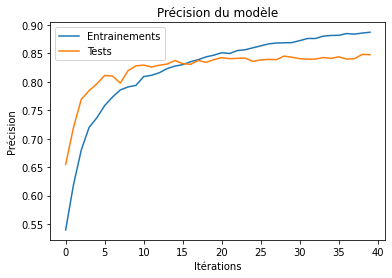

In [12]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['acc'])

# Entraine le modèle sur un certain nombre d'itérations
historique = model.fit(x_entrainement, y_entrainement, batch_size=128, epochs=40, verbose=1, validation_data=(x_test, y_test))

# Evalue le modèle avec les échantillons de tests
score = model.evaluate(x_test, y_test, verbose=0)
print('Fonction d\'objectif des tests :', score[0])
print('Précision des tests :', score[1])

# Synthèse
plt.plot(historique.history['acc'])
plt.plot(historique.history['val_acc'])
plt.title('Précision du modèle')
plt.ylabel('Précision')
plt.xlabel('Itérations')
plt.legend(['Entrainements', 'Tests'], loc='upper left')
plt.show()

# Prédictions



In [16]:
predictions = model.predict(padded_sequences)
plus_probable = predictions.argmax(1)

In [21]:
index = random.randrange(len(predictions))
print(commentaires[index])
print('Prédiction: %d, label: %d' % (plus_probable[index], ressentis[index]))

À forcer de chercher, on trouve... Deux amis voituriers qui travaillent pour un restaurant se servent de cette opportunité d'avoir la voiture du client pour aller les voler chez eux en sachant très bien que la maison sera vide. Une combine rodée jusqu'au jour où Sean pénètre dans la mauvaise maison et découvre quelque chose de terrifiant. Le propriétaire est un maniaque complètement détraqué qui va faire vivre un enfer aux jeunes hommes. "Bad Samaritan" se déroule sous une tension constante et sur un rythme effréné qui ne faiblit jamais. C'est clairement la grande force de ce thriller parfaitement mené et exécuté qui est haletant et captivant jusqu'à la dernière minute. C'est souvent tiré par les cheveux et pas toujours crédible, mais peu importe, car l'on est vraiment pris dans l'action et par ce mano à mano particulièrement intense. C'est une série B totalement assumée qui n'hésite pas à en faire des tonnes quitte à ce que ce soit risible par moment. On ne compte plus les rebondissem

# Analyse des erreurs

You get extra minutes so that you can carry out the call and not get cut off."
Prediction: 0, label: 1


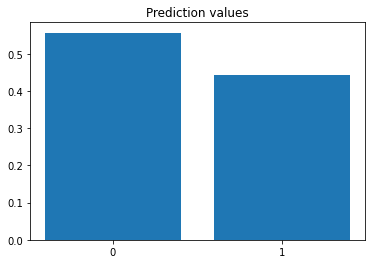

In [ ]:
for i in range(10000):
    index = random.randrange(len(predictions))
    if most_likely[index] != sentiments[index]:
        break

print(comments[index])
print('Prediction: %d, label: %d' % (most_likely[index], sentiments[index]))

plt.bar(range(num_classes), predictions[index], tick_label=range(num_classes))
plt.title('Prediction values')
plt.show()